#### **Output**: matched, cleaned csv files in `workspace/longitudinal_data.csv` and `workspace/longitudinal_events.csv`

# Match data based on study date

In [95]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from tqdm import tqdm_notebook as tqdm

In [2]:
clean_data_dir = '/storage/groups/ml01/datasets/projects/20181610_eyeclinic_niklas.koehler/dwh_tables_cleaned'


In [3]:
octs = pd.read_csv(os.path.join(clean_data_dir, 'octs_fundus_no_dups.csv'), index_col=0)
octs.study_date = pd.to_datetime(octs.study_date)

visus = pd.read_csv(os.path.join(clean_data_dir, 'visus_labels_clean.csv'), index_col=0)
visus.study_date = pd.to_datetime(visus.study_date)

thickness = pd.read_csv(os.path.join(clean_data_dir, 'thickness_maps_no_dups.csv'), index_col=0)
thickness.study_date = pd.to_datetime(thickness.study_date)

injections = pd.read_csv(os.path.join(clean_data_dir, 'injections_clean.csv'), index_col=0)
injections.study_date = pd.to_datetime(injections.study_date)

diagnosis = pd.read_csv(os.path.join(clean_data_dir, 'diagnosis_longitudinal_clean.csv'), index_col=0)
diagnosis.iol_date = pd.to_datetime(diagnosis.iol_date)

## Match OCTs, visus, thickness 
- OCTs and thickness based on study date
- visus and OCTs on same date (NEVER after injection)

number of matches increased when not accurately merging on date with with timespa

In [4]:
print('Merging {} octs with {} thickness maps'.format(len(octs), len(thickness)))
merged = pd.merge(octs, thickness, on=['patient_id', 'laterality', 'study_date'], how='left')
print('Result: {} oct/thickness pairs'.format(len(merged.dropna(subset=['thickness_path']))))

print('Merging {} octs with {} visus labels'.format(len(merged), len(visus)))
merged = pd.merge(merged, visus, on=['patient_id', 'laterality', 'study_date'], how='outer') # keep all visus labels
print('Result: {} oct/visus pairs'.format(len(merged.dropna(subset=['oct_path', 'visual_acuity']))))

#print('Merging {} octs with {} injections'.format(len(merged), len(injections)))
#merged = pd.merge(merged, injections, on=['study_date', 'patient_id', 'laterality'], how='outer') # keep all injections
#print('Result: {} oct/visus/injections pairs'.format(len(merged.dropna(subset=['oct_path', 'visual_acuity', 'MED']))))

Merging 127279 octs with 114543 thickness maps
Result: 113922 oct/thickness pairs
Merging 127279 octs with 618989 visus labels
Result: 108665 oct/visus pairs


In [5]:
# make results columns nice
merged.loc[:,'oct?'] = ~merged['oct_path'].isna()
merged.loc[:,'visus?'] = ~merged['logMAR'].isna()
merged.loc[:,'thickness?'] = ~merged['thickness_path'].isna()
merged.loc[:,'fundus?'] = ~merged['fundus_path'].isna()

oct_measurements = merged.copy()
# clean up merged table
oct_measurements = oct_measurements.drop(columns=['visual_acuity_raw', 'logMAR_raw', 'laterality_raw', 'visual_acuity_origin'])

In [6]:
disp_cols = ['patient_id', 'laterality', 'study_date', 'oct?', 'visus?', 'thickness?', 'fundus?']
oct_measurements[disp_cols]

,patient_id,laterality,study_date,oct?,visus?,thickness?,fundus?
0,363979,R,2018-01-29,True,True,True,True
1,363979,L,2018-01-29,True,True,True,True
2,350569,R,2017-03-06,True,True,True,True
3,350569,L,2017-03-06,True,True,True,True
4,185669,L,2014-12-09,True,True,False,True
...,...,...,...,...,...,...,...
637598,376148,R,2018-09-23,False,True,False,False
637599,376148,R,2018-09-25,False,True,False,False
637600,376148,R,2018-10-01,False,True,False,False
637601,376150,L,2018-11-23,False,True,False,False


## Prepare data for LSTM

### Limit oct measurements to longitudinal patients, add diagnosis

In [7]:
# merge diagnosis label to each patient instance (laterality + study date)
longitudinal_data = pd.merge(oct_measurements, diagnosis[['patient_id', 'laterality', 'diagnosis_raw', 'diagnosis']], on=['patient_id', 'laterality'], how='inner')

In [8]:
longitudinal_data

,patient_id,laterality,study_date,oct_path,fundus_path,thickness_path,visual_acuity,logMAR,oct?,visus?,thickness?,fundus?,diagnosis_raw,diagnosis
0,34537,R,2014-12-16,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,0.2,0.698970,True,True,True,True,Irvine-Gass-Syndrom,NaN
1,34537,R,2016-01-26,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,0.25,0.602060,True,True,True,True,Irvine-Gass-Syndrom,NaN
2,34537,R,2017-12-13,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,0.25,0.602060,True,True,True,True,Irvine-Gass-Syndrom,NaN
3,34537,R,2014-09-16,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,0.32,0.494850,True,True,True,True,Irvine-Gass-Syndrom,NaN
4,34537,R,2013-11-05,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/raw/2018_LMUAuge...,/storage/groups/ml01/datasets/projects/2018161...,NaN,NaN,True,False,True,True,Irvine-Gass-Syndrom,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42873,290507,R,2013-05-27,NaN,NaN,NaN,0.05,1.301030,False,True,False,False,AMD,AMD
42874,290507,R,2013-06-25,NaN,NaN,NaN,0.05,1.301030,False,True,False,False,AMD,AMD
42875,290507,R,2013-07-23,NaN,NaN,NaN,0.05,1.301030,False,True,False,False,AMD,AMD
42876,290507,R,2014-04-10,NaN,NaN,NaN,0.02857142857142857,1.544068,False,True,False,False,AMD,AMD


### Create events table with injections and surgery dates

In [9]:
longitudinal_patients = diagnosis[['patient_id', 'laterality']].drop_duplicates(['patient_id', 'laterality'])

# add injections
events = pd.merge(longitudinal_patients, injections[['patient_id', 'laterality', 'study_date', 'MED']], on=['patient_id', 'laterality'], how='inner')
events.loc[:,'injection?'] = ~events['MED'].isna()

# add lens surgery data
lens_surgery = diagnosis[['patient_id', 'laterality', 'iol_date']].copy()
lens_surgery.rename(columns={'iol_date': 'study_date'}, inplace=True)
lens_surgery['iol?'] = ~lens_surgery.study_date.isna()
lens_surgery = lens_surgery[lens_surgery['iol?']]
# limit to longitudinal data
lens_surgery = pd.merge(longitudinal_patients, lens_surgery, on=['patient_id', 'laterality'], how='inner')
# add to events
events = pd.concat([events, lens_surgery], ignore_index=True)

/home/icb/hannah.spitzer/miniconda3/envs/lode/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [10]:
events

,MED,injection?,iol?,laterality,patient_id,study_date
0,Lucentis,True,NaN,L,1557,2014-10-20
1,Lucentis,True,NaN,L,1557,2014-11-10
2,Lucentis,True,NaN,L,1557,2014-12-10
3,Lucentis,True,NaN,L,3351,2014-01-31
4,Lucentis,True,NaN,L,3351,2014-03-07
...,...,...,...,...,...,...
4646,NaN,NaN,True,R,357757,2017-08-16
4647,NaN,NaN,True,R,358308,2017-08-28
4648,NaN,NaN,True,R,358833,2017-09-11
4649,NaN,NaN,True,R,358904,2017-09-13


### Save tables

In [14]:
workspace_dir = '/storage/groups/ml01/workspace/hannah.spitzer/LODE'
longitudinal_data.to_csv(os.path.join(workspace_dir, 'longitudinal_data.csv'))
events.to_csv(os.path.join(workspace_dir, 'longitudinal_events.csv'))

### Statistics of available OCTs with visus labels and AMD or DR diagnosis

In [11]:
# exclude NaN entries
print('Starting with {} entries'.format(len(longitudinal_data)))
filtered = longitudinal_data.dropna(subset=['diagnosis', 'oct_path', 'logMAR'])
print('Non-nan entries: {}'.format(len(filtered)))
all_patients = filtered
amd_patients = filtered[filtered.diagnosis == 'AMD']
dr_patients = filtered[filtered.diagnosis == 'DR']
print('{} amd and {} dr entries remaining'.format(len(amd_patients), len(dr_patients)))

Starting with 42878 entries
Non-nan entries: 18568
15318 amd and 3250 dr entries remaining


In [113]:
def plot_sequence_length(table, ax=None):
    # length of sequences
    if ax is None:
        fig, ax = plt.subplots(1,1)
    len_ts = np.array(table.groupby(['patient_id', 'laterality']).oct_path.count())
    ax.hist(len_ts, bins=range(1,60))
    ax.set_ylabel('Number of time series')
    ax.set_xlabel('Time series length')
    
    # print median and max values
    maxval = np.max(len_ts)
    ax.text(0.95,0.95, '#ts total: {}\nmaxlen: {:.0f}'.format(len(len_ts), maxval), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')

def plot_timedelta(table, ax=None):
    # number of days between consecutive measurements
    if ax is None:
        fig, ax = plt.subplots(1,1)
    grouped = table.sort_values('study_date').groupby(['patient_id', 'laterality'])
    timedelta = np.array(grouped.apply(lambda x: x.study_date.diff()).reset_index().study_date)
    # convert to days (disreagarding NaT at the start of each group)
    timedelta = timedelta[~np.isnat(timedelta)] / np.timedelta64(1, 'D')
    
    ax.hist(timedelta, range=(1,365), bins=50)
    ax.set_ylabel('Number of measurements')
    ax.set_xlabel('Time delta [days]')
    # print median and max values
    median = np.median(timedelta)
    maxval = np.max(timedelta)
    ax.text(0.95,0.95, 'median: {:.0f} d\nmax: {:.0f} d'.format(median, maxval), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
def plot_injections(table, events, ax=None):
    # histogram of number of series with a certain number of injections
    if ax is None:
        fig, ax = plt.subplots(1,1)
    # join events and patients
    events_merged = pd.concat([table, events], ignore_index=True, sort=False)
    grouped = events_merged.groupby(['patient_id', 'laterality'])
    # drop all groups that do not have at least one OCT (introduced by merging events)
    filtered = grouped.filter(lambda x: x.oct_path.count()>0)
    grouped = filtered.groupby(['patient_id', 'laterality'])
    injections = np.array(grouped['injection?'].count())
    
    ax.hist(injections, range=(1,18), bins=range(1,19))
    ax.set_xticks(range(1,19))
    ax.set_ylabel('Number of time series')
    ax.set_xlabel('Number of injections')
    # print max value and number of 0 injections
    ax.text(0.95,0.95, 'max: {:.0f}\n#series with 0 injections: {}'.format(np.max(injections), sum(injections==0)), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')

def plot_sequence_vs_events(table, events, ax=None):
    # line plot of avg number of injections / lens surgery prob wrt length of time series
    if ax is None:
        fig, ax = plt.subplots(1,1)
    # join events and patients
    events_merged = pd.concat([table, events], ignore_index=True, sort=False)
    grouped = events_merged.groupby(['patient_id', 'laterality'])
    # drop all groups that do not have at least one OCT (introduced by merging events)
    filtered = grouped.filter(lambda x: x.oct_path.count()>0)
    grouped = filtered.groupby(['patient_id', 'laterality'])
    res = grouped['oct?', 'iol?', 'injection?'].count()
    res_agg = res.groupby(['oct?']).agg({'oct?':'count', 'iol?':'sum', 'injection?':'sum'})
    len_ts = np.array(res_agg.index)
    num_ts = np.array(res_agg['oct?'])
    lens_surgery_prob = np.array(res_agg['iol?']) / num_ts
    avg_num_injections = np.array(res_agg['injection?']) / num_ts

    # plot number of injections per length of time series
    ax.plot(len_ts, avg_num_injections, color='blue')
    ax.set_ylabel('Avg number of injections', color='blue')
    ax.set_xlabel('Time series length')
    ax.tick_params(axis='y', labelcolor='blue')

    # plot probablity of lens surgery
    ax2 = ax.twinx()
    ax2.plot(len_ts, lens_surgery_prob, color='red')
    ax2.set_ylabel('Probability of lens surgery', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # print probability of lens surgery
    ax.text(0.95,0.95, 'p(lens surgery)={:.2f}'.format(np.mean(lens_surgery_prob)), transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')


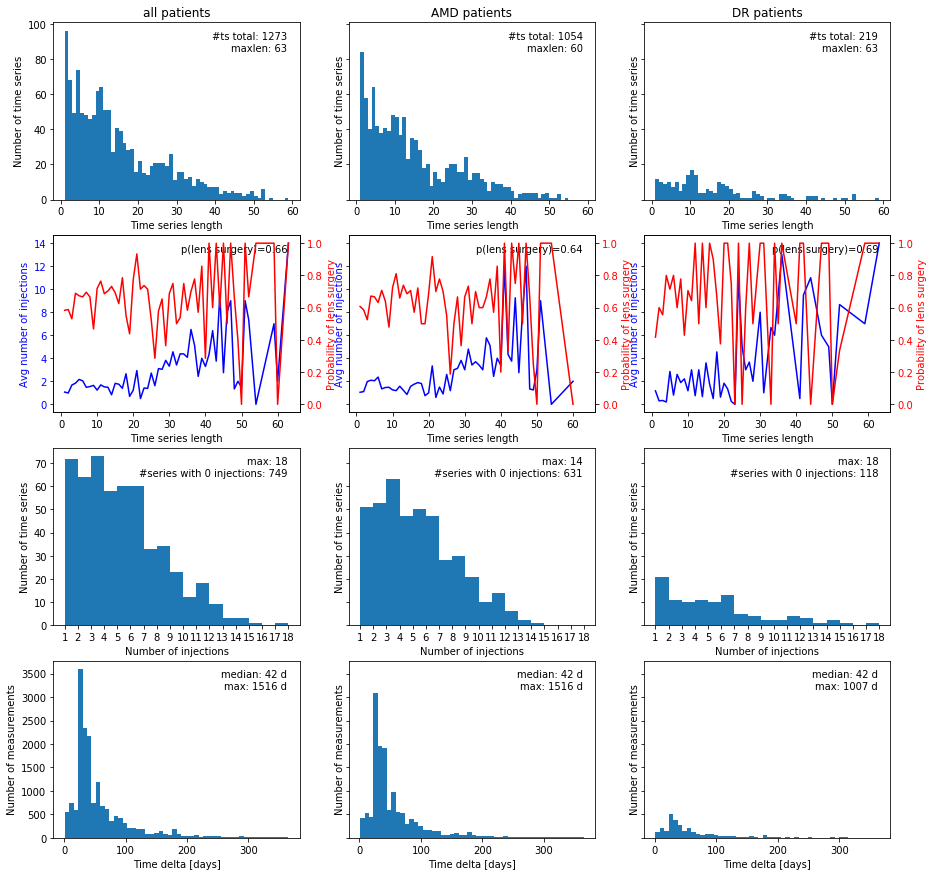

In [114]:
fig, axes = plt.subplots(4,3, sharex='row', sharey='row', figsize=(15,15))
axes[0,1].set_title('AMD patients')
axes[0,0].set_title('all patients')
axes[0,2].set_title('DR patients')
for col, table in zip(axes.T, [all_patients, amd_patients, dr_patients]):
    plot_sequence_length(table, ax=col[0])
    plot_sequence_vs_events(table, events, ax=col[1])
    plot_injections(table, events, ax=col[2])
    plot_timedelta(table, ax=col[3])
fig.savefig('longitudinal_summary_oct.png', dpi=300)  

Statistics are for OCT measurements with logMAR labels and diagnosis DR or AMD (there might be a bit more OCTs without logMAR, or logMAR without OCT)
- total of 1300 time series, ranging from length 1 to 63
- time delta between consecutive measurements is on average 42 days
- probability of lens surgery lies at ca 66%
- number of injections stays constant untill lengths ~20, then it does up to ~6 injections
- DR patients: longer time series, more injections, higher probability of lens surgery

### variation of visual acuity for each patient

In [53]:
va_values = longitudinal_data.dropna(subset=['logMAR'])
all_va = va_values
amd_va = va_values[va_values.diagnosis == 'AMD']
dr_va = va_values[va_values.diagnosis == 'DR']


In [115]:
def plot_va(table, ax=None):
    # histogram of va values distribution
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    ax.hist(table.logMAR, bins=np.arange(-0.5,3,0.25))
    ax.set_ylabel('Number of measurements')
    ax.set_xlabel('logMAR (0 good, 2 blind)')
    
def plot_diffva(table, events, ax=None):
    # histogram of va values distribution
    if ax is None:
        fig, ax = plt.subplots(1,1)
    events_merged = pd.concat([table, events], ignore_index=True, sort=False)
    grouped = events_merged.groupby(['patient_id', 'laterality'])

    lens_surgery = grouped['iol?'].any()
    diff_va = grouped.logMAR.last() - grouped.logMAR.first()
    
    ax.hist(diff_va, bins=np.arange(-2,2.5,0.125), alpha=0.5, label='all', density=False)
    #ax.hist(diff_va[lens_surgery], bins=np.arange(-2,2.5,0.125), alpha=0.5, label='with ls', density=True)
    #ax.hist(diff_va[~lens_surgery], bins=np.arange(-2,2.5,0.125), alpha=0.5, label='no ls')
    #ax.legend()
    ax.set_ylabel('Number of time series')
    ax.set_xlabel('difference between first and last measured logMAR\n(neg: improvement, pos: deterioration)')

def plot_varva(table, events, ax=None):
    # histogram of va values distribution
    if ax is None:
        fig, ax = plt.subplots(1,1)
    events_merged = pd.concat([table, events], ignore_index=True, sort=False)
    grouped = events_merged.groupby(['patient_id', 'laterality'])

    lens_surgery = grouped['iol?'].any()
    var_va = grouped.logMAR.var()
    
    ax.hist(var_va, bins=np.arange(0,1,0.05), alpha=0.5, label='all', density=False)
    #ax.hist(var_va[lens_surgery], bins=np.arange(0,1,0.05), alpha=0.5, label='with ls', density=True)
    #ax.hist(var_va[~lens_surgery], bins=np.arange(0,1,0.05), alpha=0.5, label='no ls')
    #ax.legend()
    ax.set_ylabel('Number of time series')
    ax.set_xlabel('variance of logMAR values in one time series')

def plot_va_vs_injection(table, events, ax=None):
    # 2D histogram of #injections vs va values
    if ax is None:
        fig, ax = plt.subplots(1,1)
    events_merged = pd.concat([table, events], ignore_index=True, sort=False)
    grouped = events_merged.groupby(['patient_id', 'laterality'])

    final_va = grouped.logMAR.last()
    injections = grouped['injection?'].count()[~final_va.isna()]
    final_va = final_va[~final_va.isna()]

    # normalize with power law, gamma = 0.5, to make lower values more visible
    ax.hist2d(final_va, injections, norm=mcolors.PowerNorm(0.5))
    ax.set_ylabel('Number of injections')
    ax.set_xlabel('logMAR')
    
def plot_va_vs_lens_surgery(table, events, ax=None):
    # boxplot of distribution of va values with and without lens surgery
    if ax is None:
        fig, ax = plt.subplots(1,1)
    events_merged = pd.concat([table, events], ignore_index=True, sort=False)
    grouped = events_merged.groupby(['patient_id', 'laterality'])

    final_va = grouped.logMAR.last()
    lens_surgery = grouped['iol?'].any()[~final_va.isna()]
    final_va = final_va[~final_va.isna()]

    ax.boxplot([final_va[~lens_surgery], final_va[lens_surgery]], vert=False)
    ax.set_yticklabels(['no lens surgery', 'lens_surgery'], rotation=90, va='center')
    ax.set_xlabel('logMAR')

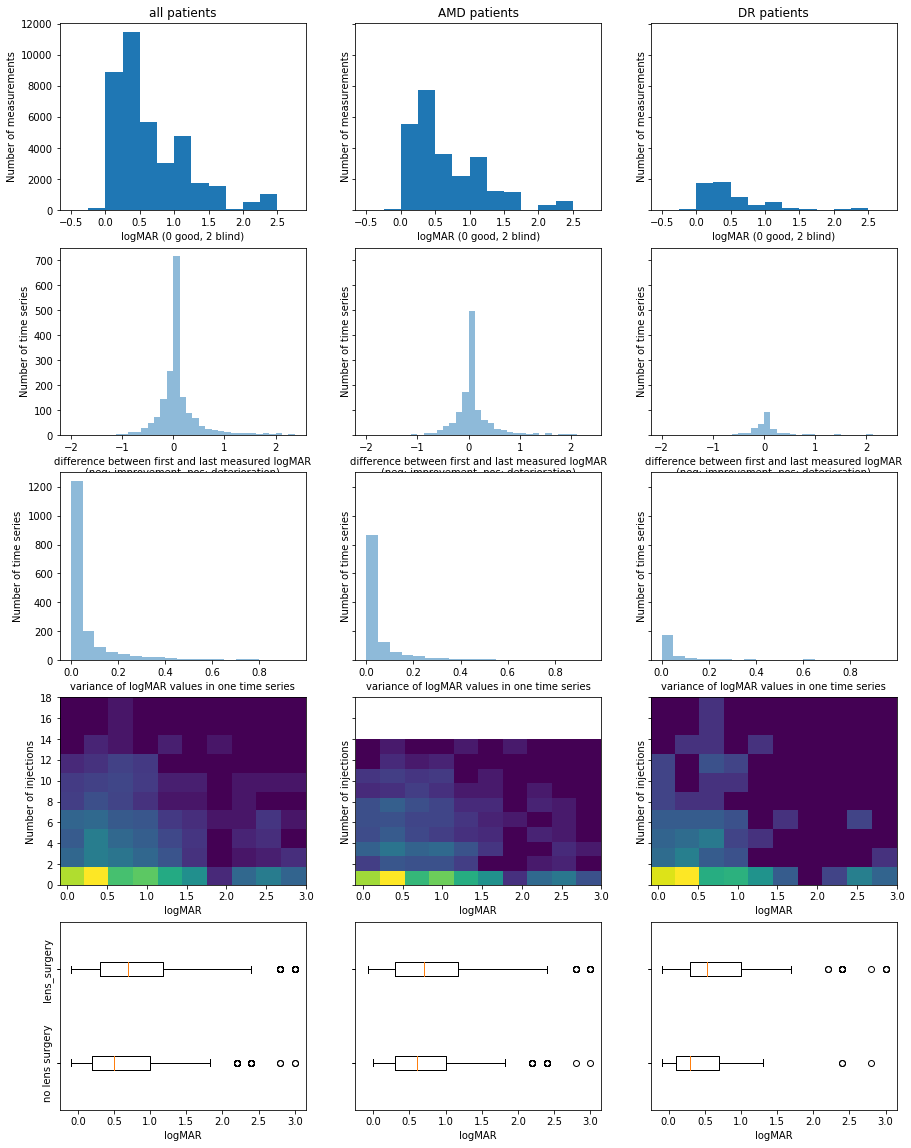

In [116]:
fig, axes = plt.subplots(5,3, sharex='row', sharey='row', figsize=(15,20))
axes[0,1].set_title('AMD patients')
axes[0,0].set_title('all patients')
axes[0,2].set_title('DR patients')
for col, table in zip(axes.T, [all_va, amd_va, dr_va]):
    plot_va(table, ax=col[0])
    plot_diffva(table, events, ax=col[1])
    plot_varva(table, events, ax=col[2])
    plot_va_vs_injection(table, events, ax=col[3])
    plot_va_vs_lens_surgery(table, events, ax=col[4])
fig.savefig('longitudinal_summary_va.png', dpi=300)    

statistics are for all va measurements
- logMAR ranges from 0 (very good) to 2.5 (artificially introduced for FZ and lilo events)
- in general, logMAR gets a little worse over the course of a time series. If lens surgery event or not does not make a difference
- variance of logMAR values in one time series is usually between 0 and 0.2
- there is no clear relationship between last logMAR and number of injections. If have a very high number of injections, do not habe a high logMAR. But this might be because those patients dont receive injections rather than injections help
- time series with lens surgery have a higher last logMAR than series with no lens surgery. Again, this might be because otherwise you don't get lens surgery.